In [1]:
import numpy as np
import torch
import sys
sys.path.append('..')
import swag
import models

import matplotlib.pyplot as plt
%matplotlib inline

## Calibration Plots on CIFAR 100

These are the calibration plots (modifications of the plots in Figure 4 of "On Calibration of Modern Neural Networks," Guo et al, https://arxiv.org/pdf/1706.04599.pdf . 

In [2]:
def compute_accuracy_by_entropy(entropy, preds, labels, bins=None):
    #def compute_acc_by_entropy_thresh(threshold, entropy, preds, labels):
    #    #
    #all_thresholds = np.unique(entropy)
    if bins is None:
        bins = np.percentile(entropy, np.arange(100))
    digitized = np.digitize(entropy, bins)
    accuracy = [np.sum(preds[digitized==i]==labels[digitized==i])/np.sum(digitized==i) for i in range(1, len(bins))]
    return accuracy, bins

In [3]:
scale_1 = np.load('bugfix_checks/scale_1.npz')
scale_diag_1 = np.load('bugfix_checks/scale_diag.npz')
scale_half = np.load('bugfix_checks/scale_half.npz')
scale_double = np.load('bugfix_checks/scale_double.npz')

/home/wesley/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  


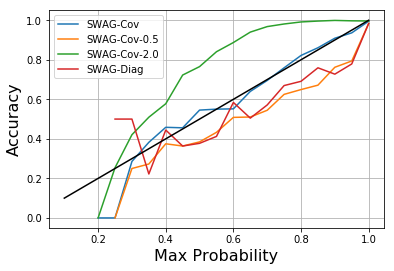

In [11]:
acc, bins = compute_accuracy_by_entropy(np.max(scale_1['predictions'],1), 
                                        np.argmax(scale_1['predictions'],1), 
                                        scale_1['targets'],
                                       bins = np.arange(0.1, 1.05, 0.05))
plt.plot(bins[1:], acc, label='SWAG-Cov')

acc, bins = compute_accuracy_by_entropy(np.max(scale_half['predictions'],1), 
                                        np.argmax(scale_half['predictions'],1), 
                                        scale_half['targets'],
                                       bins = np.arange(0.1, 1.05, 0.05))
plt.plot(bins[1:], acc, label='SWAG-Cov-0.5')

acc, bins = compute_accuracy_by_entropy(np.max(scale_double['predictions'],1), 
                                        np.argmax(scale_double['predictions'],1), 
                                        scale_double['targets'],
                                       bins = np.arange(0.1, 1.05, 0.05))
plt.plot(bins[1:], acc, label='SWAG-Cov-2.0')

acc, bins = compute_accuracy_by_entropy(np.max(scale_diag_1['predictions'],1), 
                                        np.argmax(scale_diag_1['predictions'],1), 
                                        scale_diag_1['targets'],
                                       bins = np.arange(0.1, 1.05, 0.05))
plt.plot(bins[1:], acc, label='SWAG-Diag')

plt.plot(np.arange(0.1,1.01,.01), np.arange(0.1,1.01,.01), c='black')

plt.xlabel('Max Probability', fontsize = 16)
plt.ylabel('Accuracy', fontsize = 16)
plt.grid()
plt.legend()
#plt.savefig('../plots/cifar100_calibration_1219.eps')

### Expected Calibration Error

Here I use a modified version of https://github.com/mfinzi/pristine-ml/blob/66bcfd193ea7d8e349634f554e80c6909b8e1b5c/oil/calibration.py. (Thanks Marc!)


In [8]:
def ece_loss(confidences, predictions, labels, bins):
    bin_lowers = bins[:-1]
    bin_uppers = bins[1:]
    
    accuracies = predictions > labels

    #ece = Variable(torch.zeros(1)).type_as(confidences)
    ece = 0.0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Calculated |confidence - accuracy| in each bin
        in_bin = (confidences > bin_lower) * (confidences < bin_upper)
        prop_in_bin = in_bin.mean()
        if prop_in_bin > 0:
            accuracy_in_bin = accuracies[in_bin].mean()
            avg_confidence_in_bin = confidences[in_bin].mean()
            ece += np.abs(avg_confidence_in_bin- accuracy_in_bin) * prop_in_bin

    return ece

In [12]:
swa_ece = ece_loss(np.max(swa_inclass['predictions'],1), 
                                        np.argmax(swa_inclass['predictions'],1), 
                                        swa_inclass['targets'], bins = np.arange(0.1, 1.05, 0.05))

laplace_ece = ece_loss(np.max(laplace_inclass['predictions'],1), 
                                        np.argmax(laplace_inclass['predictions'],1), 
                                        swa_inclass['targets'],
                                       bins = np.arange(0.1, 1.05, 0.05))

swagfr_cov_ece = ece_loss(np.max(swagfr_cov_inclass['predictions'],1), 
                                        np.argmax(swag_laplace_inclass['predictions'],1), 
                                        swag_laplace_inclass['targets'],
                                       bins = np.arange(0.1, 1.05, 0.05))

swag_cov_ece = ece_loss(np.max(swag_cov_inclass['predictions'],1), 
                                        np.argmax(swag_cov_inclass['predictions'],1), 
                                        swa_inclass['targets'], 
                                       bins = np.arange(0.1, 1.05, 0.05))

swag_nocov_ece = ece_loss(np.max(swag_nocov_inclass['predictions'],1), 
                                        np.argmax(swag_nocov_inclass['predictions'],1), 
                                        swa_inclass['targets'],
                                       bins = np.arange(0.1, 1.05, 0.05))

In [13]:
print(laplace_ece)
print(swa_ece)
print(swagfr_cov_ece)
print(swag_cov_ece)
print(swag_nocov_ece)

0.7604077694852638
0.764981419917196
0.6317068380278619
0.670930763719932
0.7092824569839505


In [18]:
dacc, dbins = compute_accuracy_by_entropy(np.max(dropout_inclass['predictions'],1), 
                                        np.argmax(dropout_inclass['predictions'],1), 
                                        dropout_inclass['targets'], 
                                       bins = np.arange(0.1, 1.05, 0.05))

/home/wesley/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  


In [21]:
dacc

[nan,
 nan,
 nan,
 nan,
 0.0,
 1.0,
 nan,
 0.0,
 1.0,
 0.5,
 0.6666666666666666,
 1.0,
 0.8333333333333334,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

Text(0,0.5,'Count')

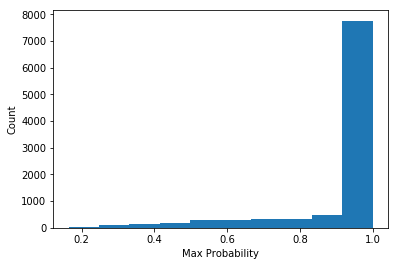

In [14]:
plt.hist(np.max(laplace_inclass['predictions'],1))
plt.xlabel('Max Probability')
plt.ylabel('Count')

In [15]:
laplace_inclass['entropies']

array([1.68156465e+00, 2.38942860e-01, 1.86902080e-02, ...,
       3.02466593e-04, 1.13445246e-02, 1.30588736e-06])